In [1]:
# установка необходимых библиотек
!pip install torch torchvision matplotlib torchsummary

In [ ]:
# импортируем библиотеки
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchsummary import summary
from torchvision import transforms, datasets

In [11]:
# определяем структуру НС для классификации изображений из датасета MNIST
class MNIST(nn.Module):
    def __init__(self): # инициализотор экземпляра класса  MNIST
        super(MNIST, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1) # сверточные слои
        self.conv2 = nn.Conv2d(32, 32, 3, 1)
        self.conv3 = nn.Conv2d(32, 64, 3, 1)
        self.conv4 = nn.Conv2d(64, 64, 3, 1)
        self.dropout1 = nn.Dropout2d(0.5) # слой отключения половины нейронов
        self.fc1 = nn.Linear(1024, 200) # полносвязные слои
        self.fc2 = nn.Linear(200, 200)
        self.fc3 = nn.Linear(200, 10) # тут 10 выходов, которые соответсвуют цифрам от 0 до 9

    def forward(self, x): # тут определяем как именно данные проходят сквозь слои
        x = self.conv1(x) # сначала первый сверточнй слой
        x = F.relu(x) # потом функция активации
        x = self.conv2(x) # второй сверточный слой
        x = F.relu(x)
        x = F.max_pool2d(x, 2) # пулинг с использованем максимума
        x = self.conv3(x)
        x = F.relu(x)
        x = self.conv4(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = torch.flatten(x, 1) # выпрямляем тензор перед передачей в полносвязные слои
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout1(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)
        return x # так х становится выходным тензором, который представляет собой оценки принадлежности к каждому из 10 классов

In [12]:
# функция обучения
def fit(model, device, train_loader, val_loader, optimizer, criterion, epochs):
    data_loader = {'train': train_loader, 'val': val_loader} # создаем словарь, который содержит загрузчики данных для разделения на выборки
    print("Fitting the model...")
    train_loss, val_loss = [], []
    train_acc, val_acc = [], []
    for epoch in range(epochs): # итерации по эпохам обучения
        loss_per_epoch, val_loss_per_epoch = 0, 0
        acc_per_epoch, val_acc_per_epoch, total, val_total = 0, 0, 0, 0
        for phase in ('train', 'val'): # итерации по фазам обучения (теннировка и валидация)
            for i, data in enumerate(data_loader[phase]): # итерации по данным внутри фазы
                inputs, labels = data[0].to(device), data[1].to(device) # перенос на gpu
                outputs = model(inputs) # получаем выходные данные модели
                preds = torch.max(outputs, 1)[1] # получаем предсказанные классы на основе выходных данных
                loss = criterion(outputs, labels) # вычисляем функцию потерь
                if phase == 'train': # ветка для операций обучения
                    acc_per_epoch += (labels == preds).sum().item() # обновление точности на текущей эпохе
                    total += labels.size(0) # обновление числа обработанных данных
                    optimizer.zero_grad() # обнуление градиентов перед обратным распространением
                    loss.backward() # обратное распространение градиентов
                    optimizer.step() # обновление весов
                    loss_per_epoch += loss.item() # обновление общей ошибки
                else: # ветка для выполнения операций валидации
                    val_acc_per_epoch += (labels == preds).sum().item() # обновление точности на текущей эпохе
                    val_total += labels.size(0) # обновление числа обработанных данных
                    val_loss_per_epoch += loss.item() # обновление общей ошибки
        # выводим статистику каждой эпохи
        print("Epoch: {} Loss: {:0.6f} Acc: {:0.6f} Val_Loss: {:0.6f} Val_Acc: {:0.6f}".format(epoch+1, loss_per_epoch/len(train_loader), acc_per_epoch/total, val_loss_per_epoch/len(val_loader), val_acc_per_epoch/val_total))
        # добавляем значения функции потерь и точности для построения графиков
        train_loss.append(loss_per_epoch/len(train_loader))
        val_loss.append(val_loss_per_epoch/len(val_loader))
        train_acc.append(acc_per_epoch/total)
        val_acc.append(val_acc_per_epoch/val_total)
    return train_loss, val_loss, train_acc, val_acc

In [13]:
# Определение трансформации и загрузка данных
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (1.0,))]) # преобразуем в вектор PyTorch и нормализуем значения тензора от 0 до 1
dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True) # загрузка датасета и применение предобработки
train_set, val_set = torch.utils.data.random_split(dataset, [55000, 5000]) # разделяем на обучающую и тестовую выборки
train_loader = torch.utils.data.DataLoader(train_set, batch_size=128, shuffle=True) # загрузчик данных для обучающей выборки
val_loader = torch.utils.data.DataLoader(val_set, batch_size=128, shuffle=True) # загрузчик данных для валидационной выборки

In [14]:
# задействуем gpu
use_cuda = True
device = torch.device("cuda" if (use_cuda and torch.cuda.is_available()) else "cpu")

In [15]:
# создание модели
model = MNIST().to(device)
summary(model, (1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 26, 26]             320
            Conv2d-2           [-1, 32, 24, 24]           9,248
            Conv2d-3           [-1, 64, 10, 10]          18,496
            Conv2d-4             [-1, 64, 8, 8]          36,928
            Linear-5                  [-1, 200]         205,000
         Dropout2d-6                  [-1, 200]               0
            Linear-7                  [-1, 200]          40,200
            Linear-8                   [-1, 10]           2,010
Total params: 312,202
Trainable params: 312,202
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.39
Params size (MB): 1.19
Estimated Total Size (MB): 1.58
----------------------------------------------------------------


In [16]:
# оптимизатор и функция потерь
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, nesterov=True, weight_decay=1e-6) # для коррекции весов модели в процессе обучения, стохастический градиентный спуск
criterion = nn.CrossEntropyLoss() # косс-энтропийная функция потерь

In [17]:
# обучение модели
train_loss, val_loss, train_acc, val_acc = fit(model, device, train_loader, val_loader, optimizer, criterion, 25)

Fitting the model...
Epoch: 1 Loss: 2.067263 Acc: 0.228636 Val_Loss: 0.522829 Val_Acc: 0.830400
Epoch: 2 Loss: 0.223827 Acc: 0.930764 Val_Loss: 0.133241 Val_Acc: 0.958600
Epoch: 3 Loss: 0.110188 Acc: 0.966691 Val_Loss: 0.100513 Val_Acc: 0.969800
Epoch: 4 Loss: 0.082630 Acc: 0.974745 Val_Loss: 0.086786 Val_Acc: 0.976400
Epoch: 5 Loss: 0.065997 Acc: 0.980255 Val_Loss: 0.073017 Val_Acc: 0.977600
Epoch: 6 Loss: 0.054161 Acc: 0.983364 Val_Loss: 0.061089 Val_Acc: 0.985400
Epoch: 7 Loss: 0.046223 Acc: 0.985600 Val_Loss: 0.056250 Val_Acc: 0.984400
Epoch: 8 Loss: 0.042252 Acc: 0.987018 Val_Loss: 0.056702 Val_Acc: 0.984000
Epoch: 9 Loss: 0.037526 Acc: 0.988345 Val_Loss: 0.052893 Val_Acc: 0.986000
Epoch: 10 Loss: 0.032645 Acc: 0.990127 Val_Loss: 0.051232 Val_Acc: 0.986000
Epoch: 11 Loss: 0.030990 Acc: 0.989909 Val_Loss: 0.044815 Val_Acc: 0.986800
Epoch: 12 Loss: 0.027211 Acc: 0.991691 Val_Loss: 0.047426 Val_Acc: 0.987400
Epoch: 13 Loss: 0.025470 Acc: 0.991782 Val_Loss: 0.055370 Val_Acc: 0.987000


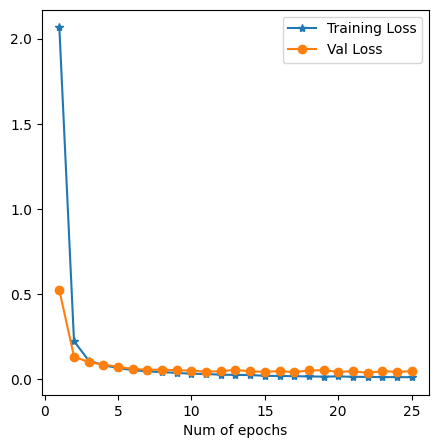

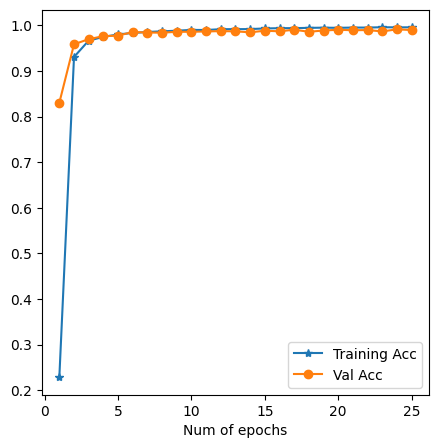

In [18]:
# строим графики
fig = plt.figure(figsize=(5, 5))
plt.plot(np.arange(1, 26), train_loss, "*-", label="Training Loss")
plt.plot(np.arange(1, 26), val_loss, "o-", label="Val Loss")
plt.xlabel("Num of epochs")
plt.legend()
plt.savefig('mnist_model_loss_event.png')

fig = plt.figure(figsize=(5, 5))
plt.plot(np.arange(1, 26), train_acc, "*-", label="Training Acc")
plt.plot(np.arange(1, 26), val_acc, "o-", label="Val Acc")
plt.xlabel("Num of epochs")
plt.legend()
plt.savefig('mnist_model_accuracy_event.png')

In [19]:
# cохраняем модель
torch.save(model.state_dict(), 'mnist_model.pt')

## Создание атаки ZOO

In [20]:
import torch
import torch.nn as nn
import torch.optim as optim

# функция атаки
def zoo_attack(model, original_image, target_label, epsilon=0.01, num_iterations=100, alpha=0.1):
    image = original_image.clone().detach().requires_grad_(True) # копия оригинального изображения

    criterion = nn.CrossEntropyLoss() # функция потерь
    optimizer = optim.SGD([image], lr=alpha) # оптимизатор

    for iteration in range(num_iterations): # цикл для оптимизации изображения с целью ухудшения классификации
        outputs = model(image) # выходы текущего изображения
        # создание тензора меток, который содержит целевой класс
        target = torch.tensor([target_label] * image.size(0), dtype=torch.long).to(image.device)
        loss = criterion(outputs, target) # вычисление функции потерь
        # коррекция изображения
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # ограничитель изменений в пределах epsilon
        image.data = torch.clamp(image.data, original_image - epsilon, original_image + epsilon) # для максимизации незаметности атаки визуально

    return image.detach()

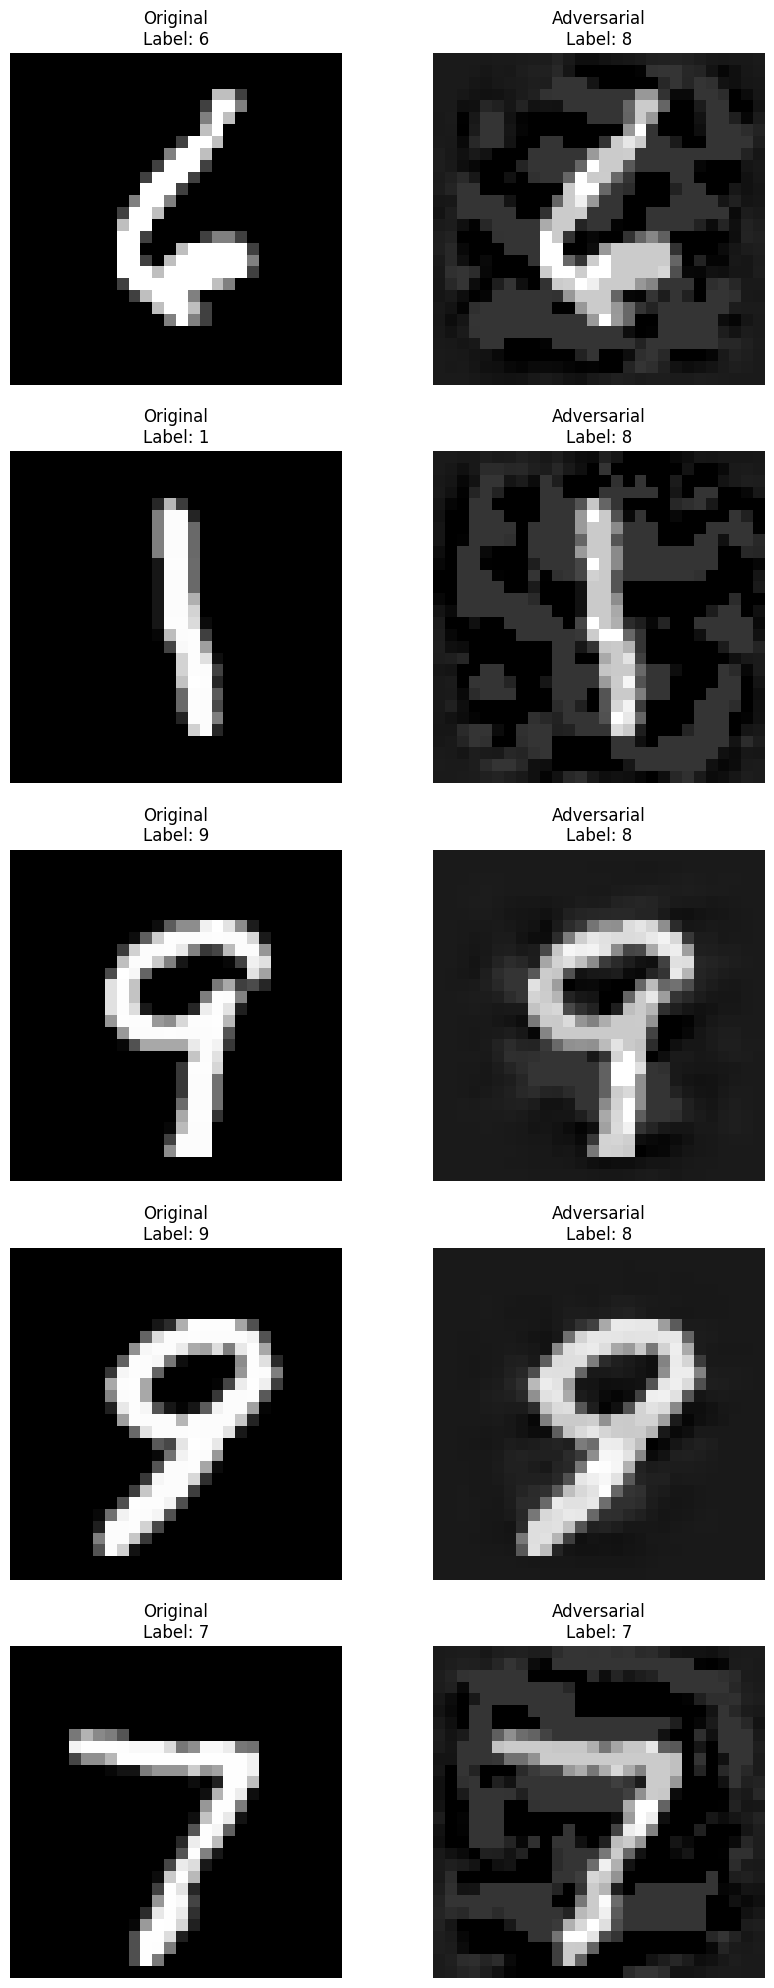

In [25]:
#model.eval()
# случайное изображение из валидационного набора
#sample_image, sample_label = next(iter(val_loader))
#sample_image, sample_label = sample_image.to(device), sample_label.to(device)
# примение атаки
#adversarial_image = zoo_attack(model, sample_image, target_label=3, epsilon=0.50, num_iterations=2000, alpha=0.02)
# результат
#with torch.no_grad():
#    model_output = model(adversarial_image)
#    predicted_labels = torch.argmax(model_output, dim=1)
# отображение изображений
#plot_images(sample_image[0], adversarial_image[0], sample_label[0].item(), predicted_labels[0].item())

model.eval() # установка режима оценки модели

# выбираем несколько случайных изображений из валидационного набора
num_samples = 5
sample_loader = torch.utils.data.DataLoader(val_set, batch_size=num_samples, shuffle=True)
sample_batch, sample_labels = next(iter(sample_loader)) # получаем батч и метки
sample_batch, sample_labels = sample_batch.to(device), sample_labels.to(device)

# создаем графики для отображения пар оригинальных и адверсариальных изображений
fig, axes = plt.subplots(num_samples, 2, figsize=(10, 5 * num_samples))

for i in range(num_samples):
    # применяем атаку к изображению
    adversarial_image = zoo_attack(model, sample_batch[i:i+1], target_label=8, epsilon=0.13, num_iterations=1000, alpha=0.02)

    # прогоняем адверсариальное изображение через модель и получаем предсказанную метку
    with torch.no_grad(): # контекст, при котором не будут обновляться веса модели
        adversarial_output = model(adversarial_image)
        adversarial_label = torch.argmax(adversarial_output, dim=1).item()

    # Отображение изображений
    axes[i, 0].imshow(sample_batch[i].cpu().numpy().squeeze(), cmap='gray')
    axes[i, 0].set_title(f"Original\nLabel: {sample_labels[i].item()}")
    axes[i, 0].axis('off')

    axes[i, 1].imshow(adversarial_image.cpu().numpy().squeeze(), cmap='gray')
    axes[i, 1].set_title(f"Adversarial\nLabel: {adversarial_label}")
    axes[i, 1].axis('off')

plt.show()